In [1]:
!pip install torchinfo

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
data_dir = "/kaggle/input/fish-data-raw/Fish Data raw/Fish Data"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Rui, Count: 2500
Class: Taki, Count: 2223
Class: Telapiya, Count: 2058
Class: Mrigel, Count: 1808
Class: Aair, Count: 1804
Class: Katla, Count: 1765
Class: Pabda, Count: 1764
Class: Boal, Count: 1651
Class: Puti, Count: 1560
Class: Tengra, Count: 1431
Class: Shol, Count: 1424
Class: Tarabaim, Count: 1262
Class: Ilish, Count: 1031
Class: Pangas, Count: 934
Class: KalBaush, Count: 917
Class: Koi, Count: 842
Class: Magur, Count: 574
Class: Foli, Count: 562
Class: Chapila, Count: 428
Class: DeshiPuti, Count: 412


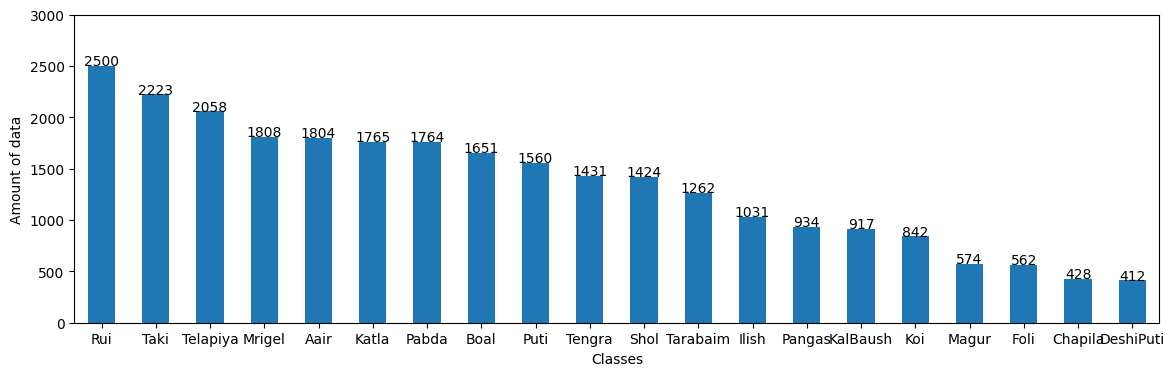

In [6]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(14, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

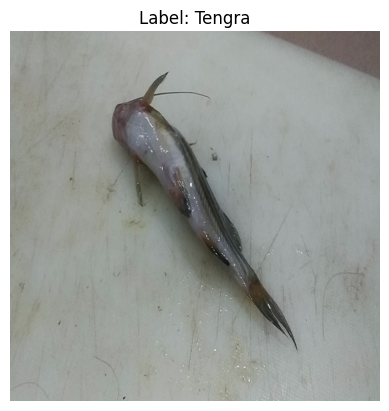

In [7]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [8]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [9]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  18865
Validation Data:  4042
Test Data:  4043
-------------------------------------------
Total amounts of data in the dataset:  26950


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [11]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [12]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        class_names = sorted(self.dataframe['label'].unique())  # Ensure consistent order
        self.label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [13]:
normalize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ImageDataset(train_dataframe, normalize, is_lb=True)
print(train_dataset.label_map)

{'Aair': 0, 'Boal': 1, 'Chapila': 2, 'DeshiPuti': 3, 'Foli': 4, 'Ilish': 5, 'KalBaush': 6, 'Katla': 7, 'Koi': 8, 'Magur': 9, 'Mrigel': 10, 'Pabda': 11, 'Pangas': 12, 'Puti': 13, 'Rui': 14, 'Shol': 15, 'Taki': 16, 'Tarabaim': 17, 'Telapiya': 18, 'Tengra': 19}


In [14]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.Resize((300,300)),   # ✅ Changed for EfficientNet-B3
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])  # ✅ add normalization (same as ImageNet)
    ])
    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

# EfficientNet B3

In [15]:
from torchvision import models
import torch.nn as nn

total_class = 20
learning_rate = 0.0001

# Load EfficientNet-B3
model = models.efficientnet_b3(pretrained=True)

# Freeze backbone
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, total_class)

# Move to device
model = model.to(device)

# Optimizer & loss
optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Model summary
summary(model, input_size=(train_batch, 3, 300, 300))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 214MB/s]


Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [32, 20]                  --
├─Sequential: 1-1                                       [32, 1536, 10, 10]        --
│    └─Conv2dNormActivation: 2-1                        [32, 40, 150, 150]        --
│    │    └─Conv2d: 3-1                                 [32, 40, 150, 150]        (1,080)
│    │    └─BatchNorm2d: 3-2                            [32, 40, 150, 150]        (80)
│    │    └─SiLU: 3-3                                   [32, 40, 150, 150]        --
│    └─Sequential: 2-2                                  [32, 24, 150, 150]        --
│    │    └─MBConv: 3-4                                 [32, 24, 150, 150]        (2,298)
│    │    └─MBConv: 3-5                                 [32, 24, 150, 150]        (1,206)
│    └─Sequential: 2-3                                  [32, 32, 75, 75]          --
│    │    └─MBConv: 3-6                    

In [16]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=30, early_stop_patience=5, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/30: 100%|██████████| 590/590 [02:36<00:00,  3.78it/s, acc=0.472, loss=2.32]

Training Loss: 2.322 Acc: 0.472


Validation Loss: 1.773 Acc: 0.775
Best model saved at epoch 1 with validation accuracy: 0.775


Epoch 2/30: 100%|██████████| 590/590 [01:55<00:00,  5.11it/s, acc=0.773, loss=1.51]

Training Loss: 1.511 Acc: 0.773


Validation Loss: 1.180 Acc: 0.852
Best model saved at epoch 2 with validation accuracy: 0.852


Epoch 3/30: 100%|██████████| 590/590 [01:53<00:00,  5.20it/s, acc=0.836, loss=1.09]

Training Loss: 1.091 Acc: 0.836


Validation Loss: 0.861 Acc: 0.880
Best model saved at epoch 3 with validation accuracy: 0.880


Epoch 4/30: 100%|██████████| 590/590 [01:53<00:00,  5.21it/s, acc=0.861, loss=0.859]

Training Loss: 0.859 Acc: 0.861


Validation Loss: 0.677 Acc: 0.903
Best model saved at epoch 4 with validation accuracy: 0.903


Epoch 5/30: 100%|██████████| 590/590 [01:53<00:00,  5.20it/s, acc=0.884, loss=0.7]  

Training Loss: 0.700 Acc: 0.884


Validation Loss: 0.563 Acc: 0.918
Best model saved at epoch 5 with validation accuracy: 0.918


Epoch 6/30: 100%|██████████| 590/590 [01:55<00:00,  5.12it/s, acc=0.895, loss=0.605]

Training Loss: 0.605 Acc: 0.895


Validation Loss: 0.487 Acc: 0.926
Best model saved at epoch 6 with validation accuracy: 0.926


Epoch 7/30: 100%|██████████| 590/590 [01:53<00:00,  5.20it/s, acc=0.907, loss=0.529]

Training Loss: 0.529 Acc: 0.907


Validation Loss: 0.409 Acc: 0.934
Best model saved at epoch 7 with validation accuracy: 0.934


Epoch 8/30: 100%|██████████| 590/590 [01:53<00:00,  5.20it/s, acc=0.914, loss=0.468]

Training Loss: 0.468 Acc: 0.914


Validation Loss: 0.363 Acc: 0.941
Best model saved at epoch 8 with validation accuracy: 0.941


Epoch 9/30: 100%|██████████| 590/590 [01:54<00:00,  5.13it/s, acc=0.916, loss=0.426]

Training Loss: 0.426 Acc: 0.916


Validation Loss: 0.330 Acc: 0.945
Best model saved at epoch 9 with validation accuracy: 0.945


Epoch 10/30: 100%|██████████| 590/590 [01:55<00:00,  5.11it/s, acc=0.927, loss=0.386]

Training Loss: 0.386 Acc: 0.927


Validation Loss: 0.293 Acc: 0.949
Best model saved at epoch 10 with validation accuracy: 0.949


Epoch 11/30: 100%|██████████| 590/590 [01:55<00:00,  5.10it/s, acc=0.932, loss=0.353]

Training Loss: 0.353 Acc: 0.932


Validation Loss: 0.268 Acc: 0.953
Best model saved at epoch 11 with validation accuracy: 0.953


Epoch 12/30: 100%|██████████| 590/590 [01:54<00:00,  5.14it/s, acc=0.934, loss=0.33] 

Training Loss: 0.330 Acc: 0.934


Validation Loss: 0.249 Acc: 0.957
Best model saved at epoch 12 with validation accuracy: 0.957


Epoch 13/30: 100%|██████████| 590/590 [01:54<00:00,  5.16it/s, acc=0.936, loss=0.311]

Training Loss: 0.311 Acc: 0.936


Validation Loss: 0.232 Acc: 0.958
Best model saved at epoch 13 with validation accuracy: 0.958


Epoch 14/30: 100%|██████████| 590/590 [01:56<00:00,  5.07it/s, acc=0.94, loss=0.294] 

Training Loss: 0.294 Acc: 0.940


Validation Loss: 0.213 Acc: 0.960
Best model saved at epoch 14 with validation accuracy: 0.960


Epoch 15/30: 100%|██████████| 590/590 [01:54<00:00,  5.14it/s, acc=0.946, loss=0.274]

Training Loss: 0.274 Acc: 0.946


Validation Loss: 0.199 Acc: 0.961
Best model saved at epoch 15 with validation accuracy: 0.961


Epoch 16/30: 100%|██████████| 590/590 [01:53<00:00,  5.18it/s, acc=0.945, loss=0.265]

Training Loss: 0.265 Acc: 0.945


Validation Loss: 0.188 Acc: 0.963
Best model saved at epoch 16 with validation accuracy: 0.963


Epoch 17/30: 100%|██████████| 590/590 [01:55<00:00,  5.10it/s, acc=0.946, loss=0.25] 

Training Loss: 0.250 Acc: 0.946


Validation Loss: 0.175 Acc: 0.966
Best model saved at epoch 17 with validation accuracy: 0.966


Epoch 18/30: 100%|██████████| 590/590 [01:54<00:00,  5.17it/s, acc=0.948, loss=0.244]

Training Loss: 0.244 Acc: 0.948


Validation Loss: 0.175 Acc: 0.969
Best model saved at epoch 18 with validation accuracy: 0.969


Epoch 19/30: 100%|██████████| 590/590 [01:55<00:00,  5.12it/s, acc=0.95, loss=0.228] 

Training Loss: 0.228 Acc: 0.950


Validation Loss: 0.162 Acc: 0.968


Epoch 20/30: 100%|██████████| 590/590 [01:55<00:00,  5.10it/s, acc=0.952, loss=0.223]

Training Loss: 0.223 Acc: 0.952


Validation Loss: 0.156 Acc: 0.970
Best model saved at epoch 20 with validation accuracy: 0.970


Epoch 21/30: 100%|██████████| 590/590 [01:54<00:00,  5.14it/s, acc=0.953, loss=0.213]

Training Loss: 0.213 Acc: 0.953


Validation Loss: 0.147 Acc: 0.970


Epoch 22/30: 100%|██████████| 590/590 [01:56<00:00,  5.07it/s, acc=0.953, loss=0.21] 

Training Loss: 0.210 Acc: 0.953


Validation Loss: 0.140 Acc: 0.973
Best model saved at epoch 22 with validation accuracy: 0.973


Epoch 23/30: 100%|██████████| 590/590 [01:55<00:00,  5.11it/s, acc=0.956, loss=0.2]  

Training Loss: 0.200 Acc: 0.956


Validation Loss: 0.135 Acc: 0.975
Best model saved at epoch 23 with validation accuracy: 0.975


Epoch 24/30: 100%|██████████| 590/590 [01:56<00:00,  5.05it/s, acc=0.956, loss=0.197]

Training Loss: 0.197 Acc: 0.956


Validation Loss: 0.132 Acc: 0.973


Epoch 25/30: 100%|██████████| 590/590 [02:01<00:00,  4.86it/s, acc=0.958, loss=0.187]

Training Loss: 0.187 Acc: 0.958


Validation Loss: 0.127 Acc: 0.974


Epoch 26/30: 100%|██████████| 590/590 [01:56<00:00,  5.05it/s, acc=0.957, loss=0.186]

Training Loss: 0.186 Acc: 0.957


Validation Loss: 0.127 Acc: 0.973


Epoch 27/30: 100%|██████████| 590/590 [02:02<00:00,  4.82it/s, acc=0.959, loss=0.18] 

Training Loss: 0.180 Acc: 0.959


Validation Loss: 0.120 Acc: 0.975


Epoch 28/30: 100%|██████████| 590/590 [01:55<00:00,  5.10it/s, acc=0.959, loss=0.176]

Training Loss: 0.176 Acc: 0.959


Validation Loss: 0.115 Acc: 0.976
Best model saved at epoch 28 with validation accuracy: 0.976


Epoch 29/30: 100%|██████████| 590/590 [01:55<00:00,  5.11it/s, acc=0.96, loss=0.172] 

Training Loss: 0.172 Acc: 0.960


Validation Loss: 0.115 Acc: 0.975


Epoch 30/30: 100%|██████████| 590/590 [01:54<00:00,  5.17it/s, acc=0.963, loss=0.166]

Training Loss: 0.166 Acc: 0.963


Validation Loss: 0.110 Acc: 0.978
Best model saved at epoch 30 with validation accuracy: 0.978
Training Time: 4277.73 seconds ---> 71.30 minutes


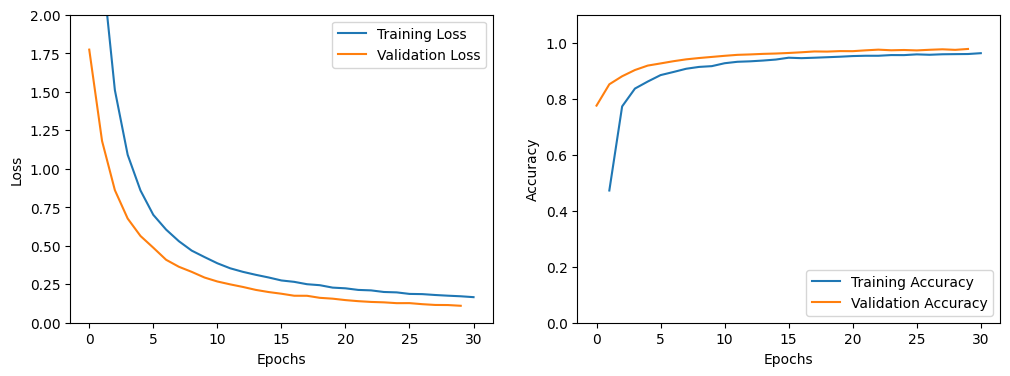

In [17]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

In [18]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [19]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.5f}")

Best model (from epoch 30) - Validation Loss: 0.110, Validation Accuracy: 0.97773


In [20]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.977
Test Time: 39.28 seconds ---> 0.65 minutes


In [21]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.5f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       271
           1       0.97      0.99      0.98       248
           2       0.98      1.00      0.99        64
           3       0.98      0.97      0.98        62
           4       1.00      1.00      1.00        84
           5       1.00      0.99      1.00       154
           6       0.92      0.98      0.95       137
           7       0.98      0.98      0.98       265
           8       1.00      1.00      1.00       126
           9       1.00      1.00      1.00        86
          10       0.98      0.99      0.98       272
          11       0.98      0.98      0.98       265
          12       1.00      1.00      1.00       140
          13       0.99      0.99      0.99       234
          14       0.97      0.95      0.96       375
          15       0.94      0.97      0.96       213
          16       0.98      0.94      0.96       334
    

> GRAD-CAM

In [40]:
def show_gradcam(model, dataloader, device, target_layer, classes, num_samples=10):
    gradcam = GradCAM(model, target_layer)

    count = 0
    plt.figure(figsize=(20, 20))

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        for i in range(inputs.size(0)):
            input_tensor = inputs[i].unsqueeze(0)

            # Ground truth label
            label = labels[i].item()

            # Forward pass to get prediction
            output = model(input_tensor)
            pred_class = output.argmax(dim=1).item()

            # Generate CAM for predicted class
            cam = gradcam.generate_cam(input_tensor, pred_class)

            # ✅ Reverse normalization
            img_np = input_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
            img_np = (img_np - np.min(img_np)) / (np.max(img_np) - np.min(img_np))
            img_np = np.uint8(255 * img_np)

            # ✅ Ensure 3 channels (in case image is grayscale)
            if img_np.ndim == 2:
                img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2BGR)

            # ✅ Resize to CAM size (224x224)
            img_np = cv2.resize(img_np, (224, 224))

            # ✅ Overlay heatmap
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            overlay = cv2.addWeighted(heatmap, 0.4, img_np, 0.6, 0)

            # Plot
            plt.subplot(num_samples // 2, 2, count + 1)
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title(f"GT: {classes[label]}, Pred: {classes[pred_class]}")
            plt.axis("off")

            count += 1
            if count >= num_samples:
                plt.show()
                gradcam.remove_hooks()
                return

    plt.show()
    gradcam.remove_hooks()


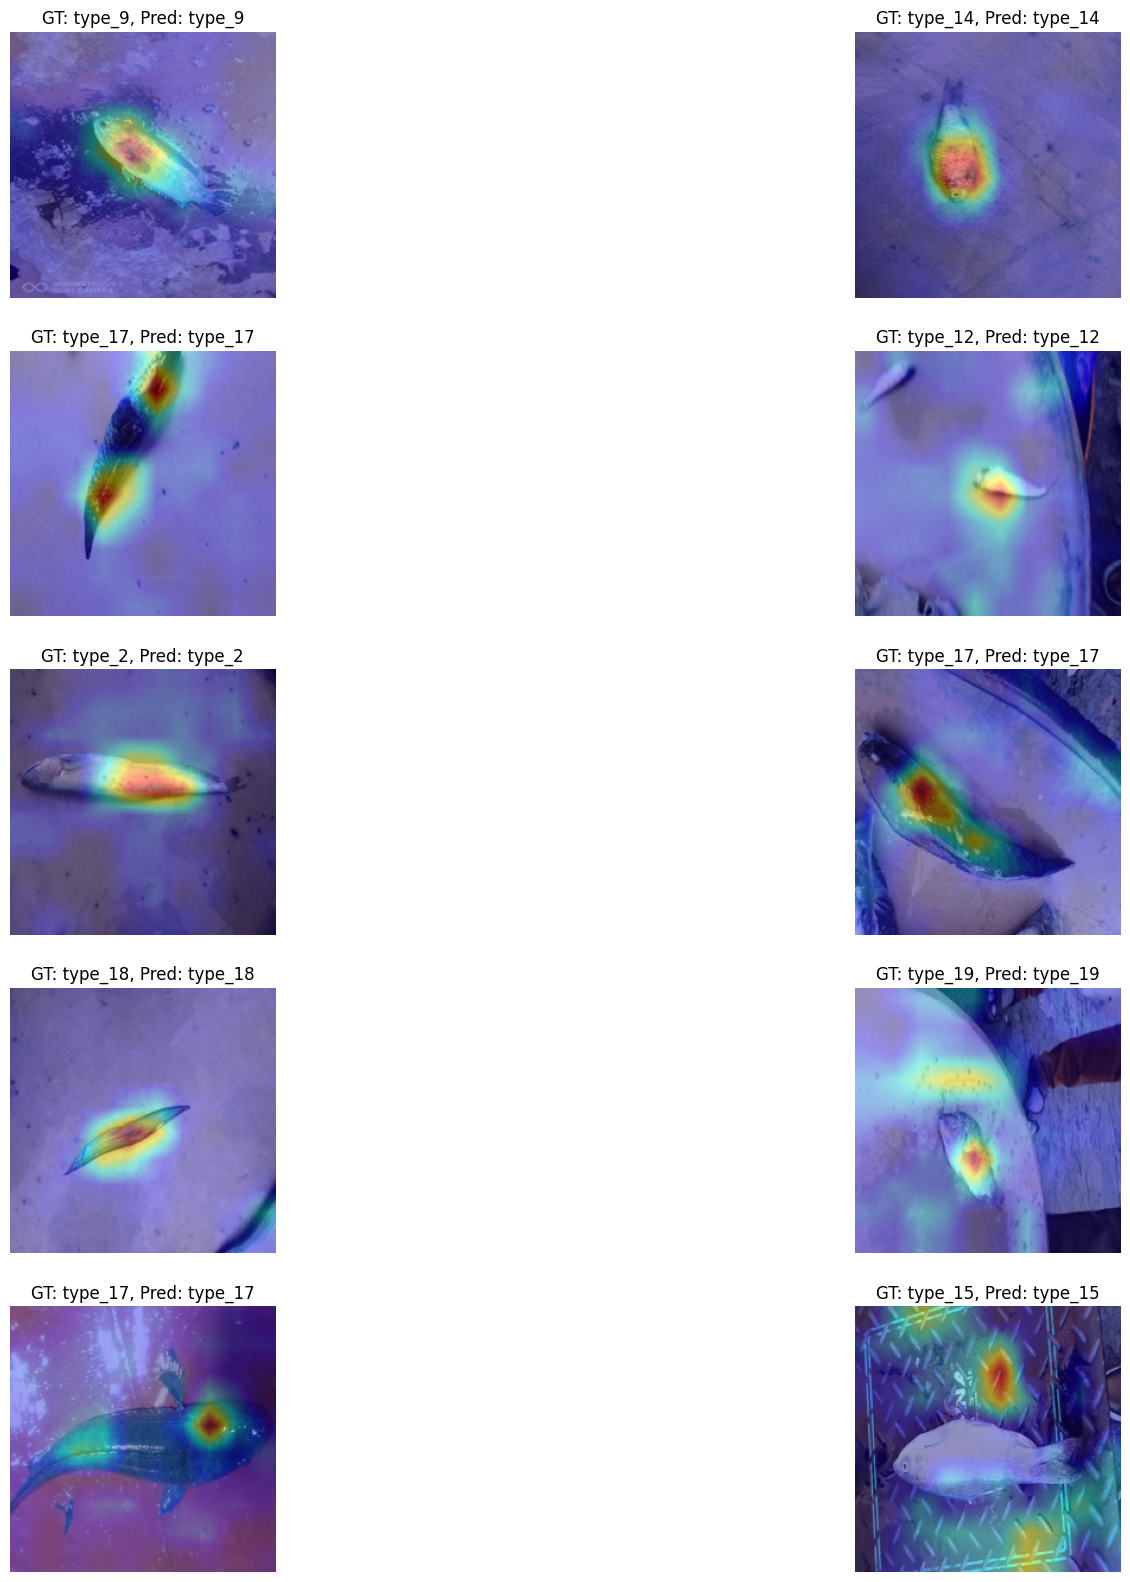

In [43]:
target_layer = model.features[-1]   # Example for EfficientNet
show_gradcam(model, dataloader_test_dataset, device, target_layer, class_names, num_samples=10)
